# Library

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import norm, skew, kurtosis, jarque_bera, kstest
from scipy import stats
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch
import matplotlib.pyplot as plt

# Data

In [ ]:
tickers = ['AMZN', 'BABA', 'EBAY', "SE"]

In [3]:
# Mendapatkan data saham TSMC (NYSE: TSM)
stocks_df = yf.download(tickers, start="2023-12-01", end="2024-11-30")['Close']

stocks_df.index = pd.to_datetime(stocks_df.index)

# Tampilkan DataFrame yang telah digabung
stocks_df

[*********************100%***********************]  3 of 3 completed


Ticker,BABA,QCOM,TSLA
Date,,,
2023-12-01,73.989998,129.669998,238.830002
2023-12-04,73.029999,129.949997,235.580002
2023-12-05,72.379997,130.750000,238.720001
2023-12-06,71.489998,129.960007,239.369995
2023-12-07,72.330002,132.940002,242.639999
...,...,...,...
2024-11-22,83.129997,156.789993,352.559998
2024-11-25,85.580002,158.820007,338.589996
2024-11-26,85.180000,156.929993,338.230011


# Log Return

In [4]:
# log_returns =  np.log(stocks_df / stocks_df.shift(1)).dropna()
log_returns =  np.log(stocks_df / stocks_df.shift(1)).dropna()
log_returns

Ticker,BABA,QCOM,TSLA
Date,,,
2023-12-04,-0.013060,0.002157,-0.013701
2023-12-05,-0.008940,0.006137,0.013241
2023-12-06,-0.012372,-0.006060,0.002719
2023-12-07,0.011681,0.022671,0.013568
2023-12-08,-0.002630,0.000226,0.004933
...,...,...,...
2024-11-22,-0.029046,0.008519,0.037335
2024-11-25,0.029046,0.012864,-0.040431
2024-11-26,-0.004685,-0.011972,-0.001064


In [5]:
log_returns.index = pd.to_datetime(log_returns.index)

In [6]:
# Gabungkan log returns dengan stocks_df_cut
combined_df = pd.concat([stocks_df, log_returns], axis=1)

# Ubah nama kolom agar lebih jelas
combined_df.columns = [f'{col}_Close' if i < len(stocks_df.columns) else f'{col}_LogReturn' 
                       for i, col in enumerate(stocks_df.columns.append(log_returns.columns))]

# Tampilkan DataFrame yang sudah digabung
combined_df

,BABA_Close,QCOM_Close,TSLA_Close,BABA_LogReturn,QCOM_LogReturn,TSLA_LogReturn
Date,,,,,,
2023-12-01,73.989998,129.669998,238.830002,NaN,NaN,NaN
2023-12-04,73.029999,129.949997,235.580002,-0.013060,0.002157,-0.013701
2023-12-05,72.379997,130.750000,238.720001,-0.008940,0.006137,0.013241
2023-12-06,71.489998,129.960007,239.369995,-0.012372,-0.006060,0.002719
2023-12-07,72.330002,132.940002,242.639999,0.011681,0.022671,0.013568
...,...,...,...,...,...,...
2024-11-22,83.129997,156.789993,352.559998,-0.029046,0.008519,0.037335
2024-11-25,85.580002,158.820007,338.589996,0.029046,0.012864,-0.040431
2024-11-26,85.180000,156.929993,338.230011,-0.004685,-0.011972,-0.001064


In [7]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2023-12-01 to 2024-11-29
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BABA_Close      251 non-null    float64
 1   QCOM_Close      251 non-null    float64
 2   TSLA_Close      251 non-null    float64
 3   BABA_LogReturn  250 non-null    float64
 4   QCOM_LogReturn  250 non-null    float64
 5   TSLA_LogReturn  250 non-null    float64
dtypes: float64(6)
memory usage: 13.7 KB


In [8]:
# from bokeh.layouts import gridplot
# from bokeh.models import ColumnDataSource, HoverTool
# from bokeh.plotting import figure, show, output_file

# # Prepare the output file
# output_file("stock_prices_log_returns.html")

# # Create a list to hold all the plots
# plots = []

# # Define the companies and their respective colors
# companies = {
#     'AMZN': 'blue',
#     'BABA': 'orange',
#     'EBAY': 'green',
#     'SE': 'red'
# }

# # Iterate over each company to create plots
# for company, color in companies.items():
#     # Create a ColumnDataSource
#     source = ColumnDataSource(data={
#         'date': combined_df.index,
#         'close': combined_df[f'{company}_Close'],
#         'log_return': combined_df[f'{company}_LogReturn']
#     })

#     # Create the closing price plot
#     p_close = figure(x_axis_type='datetime', title=f'{company} Closing Price')
#     p_close.line('date', 'close', source=source, color=color, legend_label=f'{company} Close')
#     p_close.add_tools(HoverTool(
#         tooltips=[
#             ('Date', '@date{%F}'),
#             ('Close', '@close{0.2f}')
#         ],
#         formatters={'@date': 'datetime'},
#         mode='vline'
#     ))
#     p_close.legend.location = 'top_left'
#     p_close.xaxis.axis_label = 'Date'
#     p_close.yaxis.axis_label = 'Price'
#     plots.append(p_close)

#     # Create the log return plot
#     p_log_return = figure(x_axis_type='datetime', title=f'{company} Log Return')
#     p_log_return.line('date', 'log_return', source=source, color=color, legend_label=f'{company} Log Return')
#     p_log_return.add_tools(HoverTool(
#         tooltips=[
#             ('Date', '@date{%F}'),
#             ('Log Return', '@log_return{0.4f}')
#         ],
#         formatters={'@date': 'datetime'},
#         mode='vline'
#     ))
#     p_log_return.legend.location = 'top_left'
#     p_log_return.xaxis.axis_label = 'Date'
#     p_log_return.yaxis.axis_label = 'Log Return'
#     plots.append(p_log_return)

# # Arrange plots in a 2x3 grid
# grid = gridplot([plots[:4], plots[4:]], sizing_mode='stretch_both')

# # Show the grid
# show(grid)


In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def uji_acf_pacf(log_returns, tickers):
    """
    Fungsi untuk melakukan uji ACF dan PACF pada data time series untuk setiap ticker.

    Parameters:
    log_returns (DataFrame): DataFrame yang berisi log returns, dengan setiap ticker sebagai kolom.
    tickers (list): Daftar simbol ticker yang ingin diuji ACF dan PACF-nya.

    Returns:
    None
    """
    for ticker in tickers:
        print(f"Uji ACF untuk {ticker}")
        
        # Plot ACF
        plt.figure(figsize=(10, 6))
        plot_acf(log_returns[ticker], lags=20)
        plt.title(f'ACF untuk {ticker}')
        plt.show()

        print(f"Uji PACF untuk {ticker}")
        
        # Plot PACF
        plt.figure(figsize=(10, 6))
        plot_pacf(log_returns[ticker], lags=20)
        plt.title(f'PACF untuk {ticker}')
        plt.show()

Uji ACF untuk TSLA


<Figure size 1000x600 with 0 Axes>

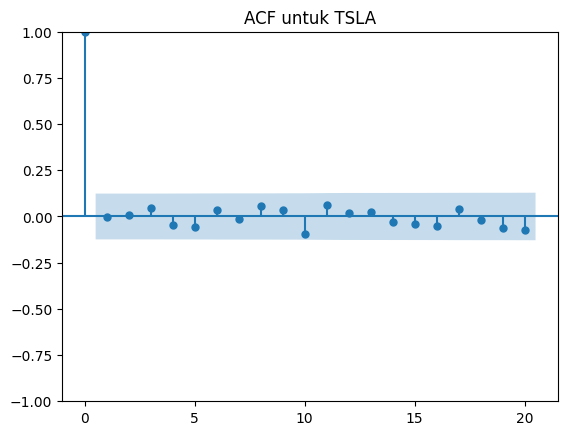

Uji PACF untuk TSLA


<Figure size 1000x600 with 0 Axes>

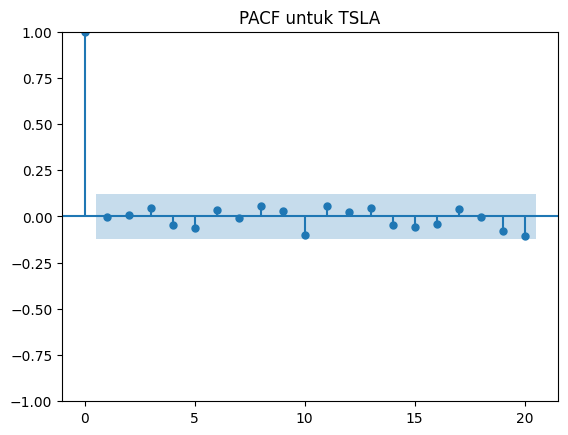

Uji ACF untuk BABA


<Figure size 1000x600 with 0 Axes>

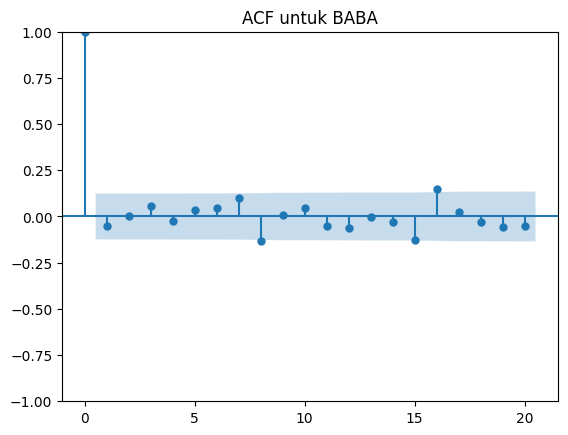

Uji PACF untuk BABA


<Figure size 1000x600 with 0 Axes>

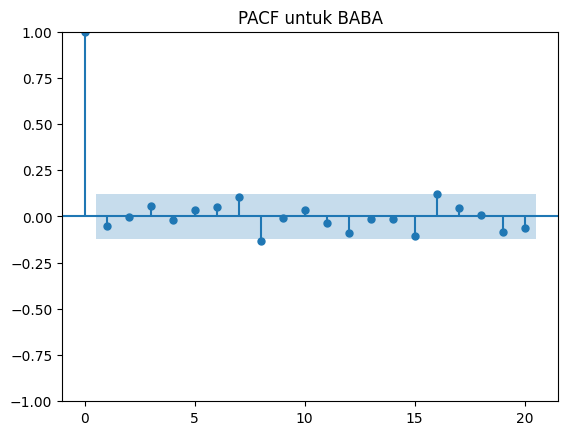

Uji ACF untuk QCOM


<Figure size 1000x600 with 0 Axes>

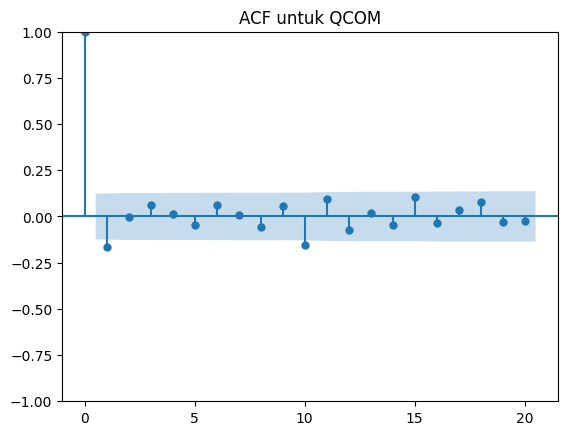

Uji PACF untuk QCOM


<Figure size 1000x600 with 0 Axes>

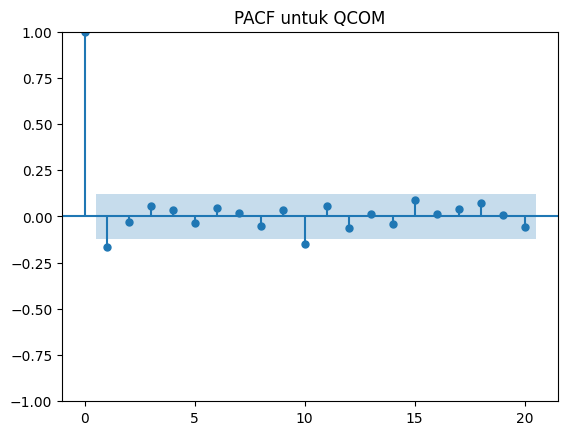

In [10]:
# Panggil fungsi uji ACF dan PACF
uji_acf_pacf(log_returns, tickers)

# Uji Normalitas Return

## Kolmogorov-Smirnov

In [11]:
# Langkah 3: Uji Normalitas (Kolmogorov-Smirnov)
def kolmogorov_smirnov_test(data):
    # Uji Kolmogorov-Smirnov terhadap distribusi normal
    stat, p_value = kstest(data, 'norm', args=(data.mean(), data.std()))
    print(f"KS Test Statistic: {stat}, p-value: {p_value}")
    if p_value < 0.05:
        print("Data tidak berdistribusi normal")
    else:
        print("Data berdistribusi normal")
    print("")

# Uji normalitas untuk masing-masing saham
for ticker in tickers:
    print(f"Uji Normalitas untuk {ticker}")
    kolmogorov_smirnov_test(log_returns[ticker])


Uji Normalitas untuk TSLA
KS Test Statistic: 0.0785303213361207, p-value: 0.08678202644806865
Data berdistribusi normal

Uji Normalitas untuk BABA
KS Test Statistic: 0.05549351439258132, p-value: 0.4098001288130556
Data berdistribusi normal

Uji Normalitas untuk QCOM
KS Test Statistic: 0.06332566713304377, p-value: 0.2576147051493286
Data berdistribusi normal



## Shapiro-Wilk

In [12]:
# Fungsi untuk uji normalitas Shapiro-Wilk
def shapiro_wilk_test(data):
    stat, p_value = stats.shapiro(data)
    print("Shapiro-Wilk Test:")
    print(f"Statistic: {stat}, p-value: {p_value}")
    if p_value > 0.05:
        print("Data mengikuti distribusi normal (p > 0.05).")
    else:
        print("Data tidak mengikuti distribusi normal (p ≤ 0.05).")
    print("")

for ticker in tickers:
    print(f"Uji Normalitas untuk {ticker}")
    shapiro_wilk_test(log_returns[ticker])

Uji Normalitas untuk TSLA
Shapiro-Wilk Test:
Statistic: 0.9407013336320122, p-value: 1.6336812238552717e-08
Data tidak mengikuti distribusi normal (p ≤ 0.05).

Uji Normalitas untuk BABA
Shapiro-Wilk Test:
Statistic: 0.9703841991235213, p-value: 4.592781330914397e-05
Data tidak mengikuti distribusi normal (p ≤ 0.05).

Uji Normalitas untuk QCOM
Shapiro-Wilk Test:
Statistic: 0.9572441305923322, p-value: 9.420097817063026e-07
Data tidak mengikuti distribusi normal (p ≤ 0.05).



## Jarque-Bera

In [13]:
# Langkah 3: Uji Normalitas (Jarque-Bera)
def jarque_bera_test(data):
    stat, p_value = jarque_bera(data)
    print(f"JB Test Statistic: {stat}, p-value: {p_value}")
    if p_value < 0.05:
        print("Data tidak berdistribusi normal")
    else:
        print("Data berdistribusi normal")
    print("")

# Uji normalitas untuk masing-masing saham
for ticker in tickers:
    print(f"Uji Normalitas untuk {ticker}")
    jarque_bera_test(log_returns[ticker])


Uji Normalitas untuk TSLA
JB Test Statistic: 205.93577553321083, p-value: 1.912557627186149e-45
Data tidak berdistribusi normal

Uji Normalitas untuk BABA
JB Test Statistic: 45.599293875261644, p-value: 1.253831411157659e-10
Data tidak berdistribusi normal

Uji Normalitas untuk QCOM
JB Test Statistic: 83.55006934018476, p-value: 7.200007709565949e-19
Data tidak berdistribusi normal



# Cornish-Fisher Expansion

In [14]:
# Langkah 1: Hitung log returns
# log_returns = np.log(stocks_df['AAPL'] / stocks_df['AAPL'].shift(1)).dropna()

# Langkah 2: Hitung skewness dan kurtosis untuk setiap saham
skewness = log_returns.apply(skew)
kurt = log_returns.apply(kurtosis)

# Langkah 3: Tentukan level kepercayaan (misalnya, 99%)
alpha = 0.05
t = 1

z_normal = norm.ppf(1 - alpha)  # Quantile untuk distribusi normal

# Langkah 4: Cornish-Fisher Expansion untuk perbaikan kuantil
def cornish_fisher(z_normal, skewness, kurt):
    """
    Menggunakan Cornish-Fisher Expansion untuk memperbaiki quantile distribusi normal.
    """
    z_cornish_fisher = z_normal + (1 / 6) * (z_normal**2 - 1) * skewness + \
                       (1 / 24) * (z_normal**3 - 3 * z_normal) * kurt - \
                       (1 / 36) * (2 * z_normal**3 - 5 * z_normal) * skewness**2
    return z_cornish_fisher

# Langkah 5: Hitung VaR untuk setiap saham
var_normal = {}
var_cornish_fisher = {}

for ticker in tickers:
    # Ambil log returns untuk ticker tersebut
    returns = log_returns[ticker]
    
    # Hitung standar deviasi log returns
    std_dev = returns.std()
    
    # Hitung VaR dengan distribusi normal
    var_normal[ticker] = -z_normal * std_dev * np.sqrt(t)
    
    # Hitung VaR dengan Cornish-Fisher Expansion
    z_cornish_fisher_val = cornish_fisher(z_normal, skewness[ticker], kurt[ticker])
    var_cornish_fisher[ticker] = -z_cornish_fisher_val * std_dev * np.sqrt(t)

# Tampilkan hasil VaR
var_df = pd.DataFrame({
    'VaR_Normal': var_normal,
    'VaR_Cornish_Fisher': var_cornish_fisher
})

var_df

,VaR_Normal,VaR_Cornish_Fisher
TSLA,-0.062712,-0.066404
BABA,-0.038161,-0.039649
QCOM,-0.039702,-0.035085


In [15]:
# Modal Awal
V0 = 10000  # Modal awal yang diinvestasikan

In [16]:
# Langkah 7: Hitung VaR dalam nilai uang
var_df['VaR Normal (USD)'] = V0 * (var_df['VaR_Normal'])
var_df['VaR Cornish-Fisher (USD)'] = V0 * (var_df['VaR_Cornish_Fisher'])
var_df

,VaR_Normal,VaR_Cornish_Fisher,VaR Normal (USD),VaR Cornish-Fisher (USD)
TSLA,-0.062712,-0.066404,-627.121543,-664.037536
BABA,-0.038161,-0.039649,-381.605823,-396.489577
QCOM,-0.039702,-0.035085,-397.015393,-350.853807


# ARCH

In [17]:
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd

# Fungsi untuk membangun dan menyesuaikan model AR
def ar_model(data):
    # Membangun model AR dengan menggunakan lags tertentu (misalnya, p=1 untuk AR(1))
    model = AutoReg(data, lags=1)
    model_fit = model.fit()
    print(model_fit.summary())  # Menampilkan ringkasan hasil model
    print("")
    return model_fit

# Modelkan AR untuk setiap ticker
for ticker in tickers:
    print("==============================================================================")
    print(f"=========================== Model AR untuk {ticker} ============================")
    print("==============================================================================")
    
    # Modelkan AR untuk data log returns masing-masing saham
    result = ar_model(log_returns[ticker])

    # Output hasil estimasi model AR
    print(result.summary())

    # Langkah berikutnya bisa dilakukan sesuai dengan analisis residual atau prediksi
    residuals = result.resid  # Mendapatkan residual dari model AR
    arch_test = het_arch(residuals)
    print(f"\nARCH LM Test p-value: {arch_test[1]}\n")

    # Jika p-value < 0.05, maka ada bukti adanya heteroskedastisitas pada residuals
    if arch_test[1] < 0.05:
        print("Terdapat heteroskedastisitas pada residuals.")
    else:
        print("Tidak terdapat heteroskedastisitas pada residuals.")
    print("\n")

=========================== Model AR untuk TSLA ============================
                            AutoReg Model Results                             
Dep. Variable:                   TSLA   No. Observations:                  250
Model:                     AutoReg(1)   Log Likelihood                 460.211
Method:               Conditional MLE   S.D. of innovations              0.038
Date:                Sat, 07 Dec 2024   AIC                           -914.422
Time:                        23:11:23   BIC                           -903.870
Sample:                             1   HQIC                          -910.175
                                  250                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.636      0.525      -0.003       0.006
TSLA.L1       -0.0030      0.063     -0.048      0.962

d:\pf\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\pf\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\pf\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



ARCH LM Test p-value: 0.019415244290627288

Terdapat heteroskedastisitas pada residuals.




In [18]:
# Langkah 4: Model ARCH/GARCH
# Memodelkan ARCH (GARCH) untuk masing-masing saham
def arch_garch_model(data):
    model = arch_model(data, vol='ARCH', p=1, rescale=False)
    model_fit = model.fit(disp="off")
    print(model_fit.summary())
    print("")
    return model_fit

# Modelkan ARCH/GARCH untuk setiap saham
for ticker in tickers:
    print("==============================================================================")
    print(f"=========================== Model ARCH untuk {ticker} ============================")
    print("==============================================================================")
    result = arch_garch_model(log_returns[ticker])

    # Output hasil estimasi model ARCH
    print(result.summary())

    # Langkah 4: Mengambil Residuals dari Model
    residuals = result.resid

    # Langkah 5: Uji Heteroskedastisitas dengan ARCH LM Test
    # Uji heteroskedastisitas (ARCH LM Test) pada residuals
    arch_test = het_arch(residuals)
    print(f"\nARCH LM Test p-value: {arch_test[1]}\n")

    # Jika p-value < 0.05, maka ada bukti adanya heteroskedastisitas pada residuals
    if arch_test[1] < 0.05:
        print("Terdapat heteroskedastisitas pada residuals.")
    else:
        print("Tidak terdapat heteroskedastisitas pada residuals.")
    print("\n")



=========================== Model ARCH untuk TSLA ============================
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   TSLA   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                462.479
Distribution:                  Normal   AIC:                          -918.959
Method:            Maximum Likelihood   BIC:                          -908.394
                                        No. Observations:                  250
Date:                Sat, Dec 07 2024   Df Residuals:                      249
Time:                        23:11:23   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------

In [19]:
import pandas as pd
import numpy as np
from scipy.stats import kstest, jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from arch import arch_model

# Assuming 'log_returns' is a DataFrame containing the log returns for each ticker
# and 'tickers' is a list of ticker symbols corresponding to the columns in 'log_returns'

# Initialize an empty list to store the results
results = []

# Function to perform diagnostic tests on residuals
def diagnostic_tests(residuals):
    # Normality Tests
    ks_stat, ks_p_value = kstest((residuals - residuals.mean()) / residuals.std(), 'norm')
    jb_stat, jb_p_value = jarque_bera(residuals)
    
    # Autocorrelation Test (Ljung-Box)
    lb_stat = acorr_ljungbox(residuals, lags=[10], return_df=True)["lb_stat"].values[0]
    lb_p_value= acorr_ljungbox(residuals, lags=[10], return_df=True)["lb_pvalue"].values[0]
    # Heteroskedasticity Test (ARCH LM Test)
    arch_stat, arch_p_value, _, _ = het_arch(residuals)
    
    return ks_stat, ks_p_value, jb_stat, jb_p_value, lb_stat, lb_p_value, arch_stat, arch_p_value

# Iterate over each ticker to fit GARCH model and perform tests
for ticker in tickers:
    # Fit GARCH(1,1) model
    model = arch_model(log_returns[ticker].dropna(), vol='GARCH', p=1, q=1, rescale=False)
    model_fit = model.fit(disp="off")
    
    # Obtain residuals
    residuals = model_fit.resid

    # Get parameter p-values dynamically
    pvalues = model_fit.pvalues
    param_pvalues = {f'{param} p-value': pval
                          for param, pval in pvalues.items()}
    param_significance = {f'{param} significance': ('Significant' if pval < 0.05 else 'Not Significant') 
                          for param, pval in pvalues.items()}
    
    # print(model_fit)
    # print(model_fit.params)
    # print(model_fit.pvalues)
    
    # Perform diagnostic tests
    ks_stat, ks_p_value, jb_stat, jb_p_value, lb_stat, lb_p_value, arch_stat, arch_p_value = diagnostic_tests(residuals)
    
    # Append results to the list
    results.append({
        'Ticker': ticker,
        'KS Test Statistic': ks_stat,
        'KS p-value': ks_p_value,
        'JB Test Statistic': jb_stat,
        'JB p-value': jb_p_value,
        'Ljung-Box Test Statistic': lb_stat,
        'Ljung-Box p-value': lb_p_value,
        'ARCH LM Test Statistic': arch_stat,
        'ARCH LM p-value': arch_p_value,
        **param_pvalues,
        **param_significance
        
    })

# Convert results list to DataFrame
results_df = pd.DataFrame(results)

# Display the summary DataFrame
results_df


,Ticker,KS Test Statistic,KS p-value,JB Test Statistic,JB p-value,Ljung-Box Test Statistic,Ljung-Box p-value,ARCH LM Test Statistic,ARCH LM p-value,mu p-value,omega p-value,alpha[1] p-value,beta[1] p-value,mu significance,omega significance,alpha[1] significance,beta[1] significance
0,TSLA,0.078530,0.086782,205.935776,1.912558e-45,5.936001,0.820611,23.148775,0.010211,0.763821,8.299704e-02,0.916210,9.747622e-31,Not Significant,Not Significant,Not Significant,Significant
1,BABA,0.055494,0.409800,45.599294,1.253831e-10,10.610618,0.388648,24.554819,0.006256,0.984831,9.778125e-09,0.178012,1.077397e-28,Not Significant,Significant,Not Significant,Significant
2,QCOM,0.063326,0.257615,83.550069,7.200008e-19,17.464217,0.064703,21.630919,0.017099,0.240585,1.197625e-28,0.321792,2.212569e-204,Not Significant,Significant,Not Significant,Significant


In [20]:
# Significance level
alpha = 0.05

# Function to determine check or cross mark
def check_mark(p_value):
    return '✓' if p_value > alpha else '✗'

# Apply function to each p-value column to create new indicator columns
results_df['Normal'] = results_df['KS p-value'].apply(check_mark)
results_df['Uncorrelated'] = results_df['Ljung-Box p-value'].apply(check_mark)
results_df['Homoskedastic'] = results_df['ARCH LM p-value'].apply(check_mark)

In [21]:
results_df

,Ticker,KS Test Statistic,KS p-value,JB Test Statistic,JB p-value,Ljung-Box Test Statistic,Ljung-Box p-value,ARCH LM Test Statistic,ARCH LM p-value,mu p-value,omega p-value,alpha[1] p-value,beta[1] p-value,mu significance,omega significance,alpha[1] significance,beta[1] significance,Normal,Uncorrelated,Homoskedastic
0,TSLA,0.078530,0.086782,205.935776,1.912558e-45,5.936001,0.820611,23.148775,0.010211,0.763821,8.299704e-02,0.916210,9.747622e-31,Not Significant,Not Significant,Not Significant,Significant,✓,✓,✗
1,BABA,0.055494,0.409800,45.599294,1.253831e-10,10.610618,0.388648,24.554819,0.006256,0.984831,9.778125e-09,0.178012,1.077397e-28,Not Significant,Significant,Not Significant,Significant,✓,✓,✗
2,QCOM,0.063326,0.257615,83.550069,7.200008e-19,17.464217,0.064703,21.630919,0.017099,0.240585,1.197625e-28,0.321792,2.212569e-204,Not Significant,Significant,Not Significant,Significant,✓,✓,✗
